In [1]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import pickle
import os
import imageio
import scipy.sparse

## Setup
In order to proceed with dataset creation, you should download COCO 2014 Train/Val annotations (241mb).  
The instructions are for Ubuntu and require wget and unzip. It works on bash Windows as well.  
wget --directory-prefix=downloads http://images.cocodataset.org/annotations/annotations_trainval2014.zip  
mkdir -p dataset/annotations  
unzip downloads/annotations_trainval2014.zip -d dataset/annotations/

In [2]:
# initialize COCO api to handle instance annotations
dataType='train2014'
annFile='downloads/dataset/annotations/instances_{}.json'.format(dataType)
coco=COCO(annFile)

loading annotations into memory...
Done (t=30.67s)
creating index...
index created!


## Dataset creation
COCO 2014 train annotations has 90 stuff classes and 82783 images
The full list of classes can be obtained by calling coco.cats

In [21]:
# Image segmentation by category/obj in gray scale/RGB
def create_dataset1ch():
    # paths
    out_dir_cat='data/coco/ground_truth/cat/'
    out_dir_obj='data/coco/ground_truth/obj/'
    out_dir_rgb_cat='data/coco/ground_truth/rgb_cat/'
    out_dir_rgb_obj='data/coco/ground_truth/rgb_obj/'
    # Set between cat and obj image creation, categories has each object related with their pixels corresponding ID,
    # obj are random coloured, making it easier for visualization
    cat_save=True
    # Set to true if you want showroom RGB images, useless for training data as
    # it's does not contains pixels corresponding categories IDs 
    rgb_save=False
    # Get all imageIDs and categories
    allImgIds = coco.getImgIds()
    allImgCat=coco.cats
    # Iterate in all images notations to create segmentation the corresponding segmentation image 
    for IM in range(0,1):
    #     Get all image IDs
        imgIds=coco.getImgIds(imgIds = allImgIds)
    #     Load corresponding image by it's ID
        img = coco.loadImgs(imgIds)[IM]
    #     Get annotations by it's image's ID
        annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
    #     Load annotations by it's corresponding IDs
        anns = coco.loadAnns(annIds)
    #     Create matrix with the same size as original image to store classes in both gray and RGB scales 
        seg_imageGray=np.zeros((img['height'],img['width'])).astype(np.uint8)
        seg_imageRGB=np.zeros((img['height'],img['width'],3)).astype(np.uint8)
    #     For each image annotation, extract their corresponding pixels objects
    # each image can have multiple annotations
        for i in range(len(anns)):
    #         Get object mask
            seg_image=coco.annToMask(anns[i])
    #     Check for pixels in common and remove from image as solution to overlapping images
            seg_image=(seg_image-(seg_image&seg_imageGray))
    #     Handle the creation of RGB images, just for showroom 
            if rgb_save==True:
    #         Create a matrix with the same size as image, but with 3 channels 
                imgRGB = np.zeros((img['height'],img['width'],3))
    #     Get random values for color mask [0,1] and store objects pixels in the matrix
                color_mask = np.random.random((1, 3)).tolist()[0]
                imgRGB[:,:,0]=((seg_imageGray|seg_image)==1)*color_mask[0]
                imgRGB[:,:,1]=((seg_imageGray|seg_image)==1)*color_mask[1]
                imgRGB[:,:,2]=((seg_imageGray|seg_image)==1)*color_mask[2]
    #             Add coloured object into the main RGB image
                seg_imageRGB=seg_imageRGB+imgRGB
    #     save images (categories/objects and RGB/gray)
            if cat_save==True:
                seg_imageGray=(seg_imageGray+((seg_imageGray|seg_image)==1)*(anns[i]['category_id']+50))
            else:
                seg_imageGray=(seg_imageGray+((seg_imageGray|seg_image)==1)*(50+anns[i]['category_id']+(110//len(anns))*i))
        if cat_save==True:
            imageio.imsave(out_dir_cat+img['file_name'], seg_imageGray.astype(np.uint8))
            if rgb_save==True:
                imageio.imsave(out_dir_rgb_cat+img['file_name'], Norm(seg_imageRGB,0,255).astype(np.uint8))
        else:
            imageio.imsave(out_dir_obj+img['file_name'], seg_imageGray.astype(np.uint8))
            if rgb_save==True:
                imageio.imsave(out_dir_rgb_obj+img['file_name'], Norm(seg_imageRGB,0,255).astype(np.uint8))

## Dataset creation with n ground truth channels
each category needs to have it's own channel, in order to archive that we will develop a new function based on the older one tha handles dataset creation (wrongly =/) with just one channel.  

Steps:
1. list every categorie available (80 categories, ranging from 1 to 90 IDs -_-)  
2. create matrix with 90 channels
3. on every image do:
4. get object segmentation
5. check it's category
6. add it on the corresponding channel
    * But what if we have more than one object in the same cattegory? We just need to use OR operator instead sum each object into the matrix.
7. save matrix using np.save()
    * if you want to see each channel, just use imageio.imsave() and don't forget to multiply it by 255 
    
Done that we should be able to train our network (hopefuly)

## Todo:
We need to optimize dataset storing because what we had described above takes to much space. Each numpy file takes around 20mb and we have ~80k images
- [ ] Metadata saver
    * save each channel in csv/json/txt containing:
        * image size
        * cat 0
            * ground truth of all objects labeled with the corresponding cat and compressed in just one matrix
        * cat N
            * only categories that has pixels > 0 
            * we will store the hole matrix for that cat
- [ ] Metadata loader
    * load metadata saved by metadata saver and create np.array(image size,91 channels)
    * channel 0 should contain ground truth of all
    * load cat N by doing array :, : , N = matrix N stored in metadata 

In [18]:
# Image segmentation by category/obj in gray scale/RGB
def create_datasetNch():
    # paths
    out_dir_cat='data/coco/ground_truth/cat/'
    out_dir_obj='data/coco/ground_truth/obj/'
    out_dir_rgb_cat='data/coco/ground_truth/rgb_cat/'
    out_dir_rgb_obj='data/coco/ground_truth/rgb_obj/'
    # Set between cat and obj image creation, categories has each object related with their pixels corresponding ID,
    # obj are random coloured, making it easier for visualization
    cat_save=True
    # Set to true if you want showroom RGB images, useless for training data as
    # it's does not contains pixels corresponding categories IDs 
    rgb_save=False
    # Get all imageIDs and categories
    allImgIds = coco.getImgIds()
    allImgCat=coco.cats
    # Iterate in all images notations to create segmentation the corresponding segmentation image 
    for IM in range(0,20):
    #     Get all image IDs
        imgIds=coco.getImgIds(imgIds = allImgIds)
    #     Load corresponding image by it's ID
        img = coco.loadImgs(imgIds)[IM]
    #     Get annotations by it's image's ID
        annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
    #     Load annotations by it's corresponding IDs
        anns = coco.loadAnns(annIds)
    #     Create matrix with the same size as original image to store classes in both gray and RGB scales
        seg_imageNch=np.zeros((img['height'],img['width'],90)).astype(np.uint8)
        seg_imageGray=np.zeros((img['height'],img['width'])).astype(np.uint8)
        seg_imageRGB=np.zeros((img['height'],img['width'],3)).astype(np.uint8)
    #     For each image annotation, extract their corresponding pixels objects
    # each image can have multiple annotations
        for i in range(len(anns)):
    #         Get object mask
            seg_image=coco.annToMask(anns[i])
#             Add object to it's corresponding channel
            seg_imageNch[:,:,anns[i]['category_id']-1]=seg_imageNch[:,:,anns[i]['category_id']-1]|seg_image
    #     Check for pixels in common and remove from image as solution to overlapping images
            seg_image=(seg_image-(seg_image&seg_imageGray))
    #     Handle the creation of RGB images, just for showroom 
            if rgb_save==True:
    #         Create a matrix with the same size as image, but with 3 channels 
                imgRGB = np.zeros((img['height'],img['width'],3))
    #     Get random values for color mask [0,1] and store objects pixels in the matrix
                color_mask = np.random.random((1, 3)).tolist()[0]
                imgRGB[:,:,0]=((seg_imageGray|seg_image)==1)*color_mask[0]
                imgRGB[:,:,1]=((seg_imageGray|seg_image)==1)*color_mask[1]
                imgRGB[:,:,2]=((seg_imageGray|seg_image)==1)*color_mask[2]
    #             Add coloured object into the main RGB image
                seg_imageRGB=seg_imageRGB+imgRGB
    #     save images (categories and RGB/gray)
            seg_imageGray=(seg_imageGray+((seg_imageGray|seg_image)==1)*(anns[i]['category_id']+50))
#         for ch in range(len(allImgCat)):
#             if np.max(seg_imageNch[:,:,ch])>0:
#                 imageio.imsave(out_dir_cat+img['file_name']+str(ch)+'.jpg', seg_imageNch[:,:,ch]*255)
#         imageio.imsave(out_dir_cat+img['file_name'], seg_imageGray.astype(np.uint8))
        np.save(out_dir_cat+img['file_name'],allow_pickle=False,seg_imageNch)
        if rgb_save==True:
            imageio.imsave(out_dir_rgb_cat+img['file_name'], Norm(seg_imageRGB,0,255).astype(np.uint8))        

80


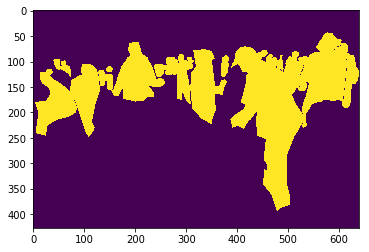

In [20]:
allImgCat=coco.cats
print(len(allImgCat))
# print(allImgCat)
create_datasetNch()
dt=np.load('data/coco/ground_truth/cat/'+'COCO_train2014_000000262145.jpg.npy')
plt.imshow(dt[:,:,0])

## Interesting stuffs

* SegNet: A Deep Convolutional Encoder-Decoder Architecture for Image Segmentation  
    https://arxiv.org/pdf/1511.00561.pdf